In [79]:
#configure dataset
from os import listdir

directory_name = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
image_names = listdir(directory_name)
image_names.remove('.DS_Store')
print(image_names[:5])


['abraham_grampa_simpson_0.jpg', 'abraham_grampa_simpson_1.jpg', 'abraham_grampa_simpson_10.jpg', 'abraham_grampa_simpson_11.jpg', 'abraham_grampa_simpson_12.jpg']


In [131]:
#calculate mean width and lenght
width = 0
lenght = 0
for i in range(0, images_size):
    path_file = os.path.join(directory_name, image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    lenght += image.shape[1]

width_mean = width//images_size
lenght_mean = lenght//images_size
dim_size = (width_mean + lenght_mean) // 2

print("Width mean: {}".format(width_mean))
print("Lenght mean: {}".format(lenght_mean))
print("Size mean dimension: {}".format(dim_size))

Width mean: 152
Lenght mean: 147
Size mean dimension: 149


In [132]:
#(149, 147), so we can redefine as (150, 150)
dim_size = 150

In [133]:
#load images
import os, random
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

images_size = len(image_names)

#resizing and labeling
images = []
labels = []
for i in range(0, images_size):
    path_file = os.path.join(directory_name, image_names[i])
    image = imread(path_file)
    image = imresize(image, (dim_size, dim_size))
    images.append(image)
    label = image_names[i].split('_')[:-1]
    labels.append('_'.join(label))

print("Loaded {} test images".format(len(images)))

Loaded 990 test images


Label:lisa_simpson, Image:584, Shape:(150, 150, 3)


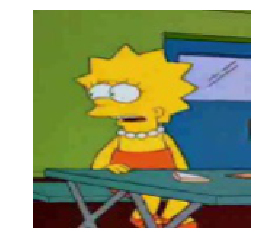

Label:apu_nahasapeemapetilon, Image:81, Shape:(150, 150, 3)


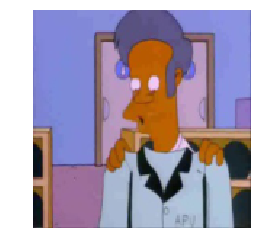

Label:charles_montgomery_burns, Image:183, Shape:(150, 150, 3)


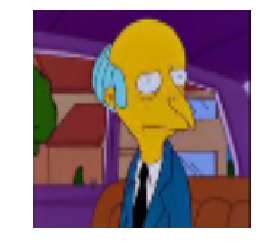

In [134]:
#show some examples
for i in range(0,3):
    idx = random.randint(0, images_size)
    image = images[idx]
    print("Label:{}, Image:{}, Shape:{}".format(labels[idx], idx, image.shape))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
#build the network
import tensorflow as tf

###